In [ ]:
# %load ../import.py
import quandl
quandl.ApiConfig.api_key = 'MBMzvkxtv63KjFEV-tL6'
from quandl.errors.quandl_error import NotFoundError

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
from sklearn import linear_model

import ipywidgets as widgets 
from ipywidgets import  interact, interactive, fixed, interact_manual
from IPython.display import display

#####################################################################################
# From tensorflow includes
import math
from matplotlib import cm
from matplotlib import gridspec
# from matplotlib import pyplot as plt

from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset


# For elongating day 
from datetime import timedelta

In [36]:
s_list=pd.read_csv("../sector_list.csv")

In [37]:
d1_col=['Date','Ticker','Open','High','Low','Last','Close',
                         'Total Trade Quantity','Turnover (Lacs)']
d2_col=['Date','Value','Tick','R','Period']


def select_sector(sector_name):    
    price_file="../Price/Data/"+sector_name+".csv"
    ratio_file="../Ratio/Data/"+sector_name+".csv"
    
    d1=pd.read_csv(str(price_file), names=d1_col, header=None, parse_dates=['Date'])
    d2=pd.read_csv(str(ratio_file), names=d2_col, header=None, parse_dates=['Date'])
    
    d1=d1[1:]
    
    
    return [d1,d2]

sector_value=widgets.Dropdown(
                            options=s_list['sector'], 
                            description="Sector:"
                            )
w=widgets.interactive(select_sector, sector_name=sector_value)
display(w)

aW50ZXJhY3RpdmUoY2hpbGRyZW49KERyb3Bkb3duKGRlc2NyaXB0aW9uPXUnU2VjdG9yOicsIG9wdGlvbnM9KCdBR1JPX0lOUFVUUycsICdBVVRPTU9CSUxFUycsICdBVVRPX0FOQ0lMTEFSSUXigKY=


## 1. Creating panel p1 for prices

In [66]:
d1=w.result[0]
d2=w.result[1]

d1=d1[~d1.duplicated()]
d2=d2[~d2.duplicated()]

In [67]:
d1.head()

,Date,Ticker,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
1,2006-08-21,NSE/ABAN,1249.85,1275.9,1201.05,1224.0,1224.00,135333.0,1698.79
2,2006-08-22,NSE/ABAN,1245.00,1249.0,1190.00,1200.0,1199.15,53138.0,643.58
3,2006-08-23,NSE/ABAN,1212.00,1216.0,1191.40,1208.0,1200.35,39103.0,470.01
4,2006-08-24,NSE/ABAN,1200.05,1295.0,1190.05,1286.0,1280.80,298335.0,3768.50
5,2006-08-25,NSE/ABAN,1218.00,1310.0,1218.00,1274.0,1266.80,58259.0,741.58


In [68]:
d2["Ticker"]="NSE/"+d2["Tick"]
d2["Ratio"]=d2["R"]+"_"+d2["Period"]
d2.head()

,Date,Value,Tick,R,Period,Ticker,Ratio
0,2012-12-31,84874.0,WALCHANNAG,BSEVOL,Q,NSE/WALCHANNAG,BSEVOL_Q
1,2013-03-31,83801.0,WALCHANNAG,BSEVOL,Q,NSE/WALCHANNAG,BSEVOL_Q
2,2013-06-30,27922.0,WALCHANNAG,BSEVOL,Q,NSE/WALCHANNAG,BSEVOL_Q
3,2013-09-30,7918.0,WALCHANNAG,BSEVOL,Q,NSE/WALCHANNAG,BSEVOL_Q
4,2013-12-31,21940.0,WALCHANNAG,BSEVOL,Q,NSE/WALCHANNAG,BSEVOL_Q


In [69]:
d1_date=d1['Date'].unique()
d1_date.sort()
minor_axis=list(d1.columns[2:])
minor_axis.append("Return")
p1=pd.Panel(major_axis=d1_date, minor_axis= minor_axis)


In [70]:
for t in d1["Ticker"].unique():
    
    p1_data=d1.loc[d1['Ticker']==t]
    del p1_data["Ticker"]
        
    p1_data.set_index('Date', inplace=True)    
    
    # shift moves dates back by 1. and calc returns on closing price
    p1_data.loc[:, "Return"]=p1_data[["Close"]].apply( lambda x: np.log( x/x.shift(1) ) )    
    
    p1[t]=p1_data

p1

<class 'pandas.core.panel.Panel'>
Dimensions: 131 (items) x 3733 (major_axis) x 8 (minor_axis)
Items axis: NSE/ABAN to NSE/TNTELE
Major_axis axis: 2003-04-15 00:00:00 to 2018-04-13 00:00:00
Minor_axis axis: Open to Return

In [71]:
p1[t].head()

,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs),Return
2003-04-15,10.00,10.00,8.90,8.90,9.00,316.0,0.03,NaN
2003-04-16,9.05,9.35,8.50,9.35,8.60,1861.0,0.16,-0.045462
2003-04-17,8.40,8.50,8.00,8.25,8.25,3800.0,0.31,-0.041549
2003-04-21,8.55,9.35,8.30,9.30,9.10,4745.0,0.42,0.098061
2003-04-22,9.25,9.90,8.85,9.50,9.50,1987.0,0.18,0.043017


In [72]:
d2_date=d2['Date'].unique()
d2_date.sort()
p2=pd.Panel(major_axis=d2_date, minor_axis=d2["Ratio"].unique())

In [73]:
for t in d2["Ticker"].unique():
    
    p2_data=d2[d2["Ticker"]==t]
    
    del p2_data['Ticker']
    del p2_data['Tick']
    
    p2_data=p2_data.pivot_table(index="Date", columns="Ratio", values="Value")
   
    p2_data.sort_index()
    
    p2[t]=p2_data
    
p2

<class 'pandas.core.panel.Panel'>
Dimensions: 123 (items) x 24 (major_axis) x 34 (minor_axis)
Items axis: NSE/WALCHANNAG to NSE/VGUARD
Major_axis axis: 2012-06-30 00:00:00 to 2018-03-31 00:00:00
Minor_axis axis: BSEVOL_Q to TI_Q

## Merge only if both p and p2 are avialble as one is from NSE and other is from D'Market 

In [74]:
items=p1.items.intersection(p2.items)
print("P1 Total Item :{0}".format(len(p1.items)) )
print("P2 Total Item :{0}".format(len(p2.items)) )
print("P3 Total Item :{0}".format(len(items)) )

P1 Total Item :131
P2 Total Item :123
P3 Total Item :123


In [75]:
p3_index_list = list(p1.major_axis) + list(p2.major_axis) 
p3_index_list=set(p3_index_list)
p3_index_list=list(p3_index_list)
p3_index_list.sort()

p3_index=pd.date_range(min(p3_index_list), max(p3_index_list), freq="1d")

p3_col   = list(p1.minor_axis) + list(p2.minor_axis)

In [76]:
p3=pd.Panel(major_axis=p3_index_list, minor_axis=p3_col)
p3

<class 'pandas.core.panel.Panel'>
Dimensions: 0 (items) x 3741 (major_axis) x 42 (minor_axis)
Items axis: None
Major_axis axis: 2003-04-15 00:00:00 to 2018-04-13 00:00:00
Minor_axis axis: Open to TI_Q

In [77]:
for item in items: 
   
    p1_data=p1[item]
    p2_data=p2[item]
    
    p3_data=pd.merge(p1_data,p2_data, how="outer", left_index=True, right_index=True)
    
    p3[item]=p3_data
    
p3

<class 'pandas.core.panel.Panel'>
Dimensions: 123 (items) x 3741 (major_axis) x 42 (minor_axis)
Items axis: NSE/ABAN to NSE/TNTELE
Major_axis axis: 2003-04-15 00:00:00 to 2018-04-13 00:00:00
Minor_axis axis: Open to TI_Q

## Remove past years with no finaincal data

In [78]:
test=p3[p3.items[0]]
test[test.index.duplicated()]

,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs),Return,BSEVOL_Q,EQCAP_Q,...,TAX_Q,BSEO_Q,FV_Q,OP_Q,DEP_Q,EBIDTSH1Q_Q,EBIDT_Q,EPS_Q,BSEL_Q,TI_Q


In [79]:
# p3.reindex(major_axis=p3_index)
drop_min= p1.major_axis.min()
drop_max= p2.major_axis.min()
drop_range=pd.date_range(drop_min, drop_max, freq="1d")
p3

<class 'pandas.core.panel.Panel'>
Dimensions: 123 (items) x 3741 (major_axis) x 42 (minor_axis)
Items axis: NSE/ABAN to NSE/TNTELE
Major_axis axis: 2003-04-15 00:00:00 to 2018-04-13 00:00:00
Minor_axis axis: Open to TI_Q

In [80]:
p3=p3.loc[:,drop_max:,:]
p3[p3.items[1]]["BSEVOL_Q"].unique()

array([          nan, 5.1970000e+03, 7.7260000e+03, 4.0335000e+04,
       8.6300000e+03, 1.3834000e+04, 9.3122000e+04, 1.0728000e+04,
       9.8030000e+03, 4.1909000e+04, 1.1441000e+04, 5.8480000e+03,
       3.9160000e+03, 3.5410000e+03, 1.9860000e+04, 4.5450000e+03,
       3.2450000e+03, 1.5880000e+03, 1.5897000e+04, 4.7640000e+03,
       4.8190000e+03, 8.6356691e+07])

In [81]:
#  Adding 7 days here for prediction

# nmber of dates to ad: 

min_date=min(p3.major_axis)
max_date=max(p3.major_axis)
idx=pd.date_range(min_date, max_date)
idx
p3.reindex(major_axis=idx)

<class 'pandas.core.panel.Panel'>
Dimensions: 123 (items) x 2114 (major_axis) x 42 (minor_axis)
Items axis: NSE/ABAN to NSE/TNTELE
Major_axis axis: 2012-06-30 00:00:00 to 2018-04-13 00:00:00
Minor_axis axis: Open to TI_Q

### Find firms inactive for 30 days

In [82]:
p3[p3.items[0]]

,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs),Return,BSEVOL_Q,EQCAP_Q,...,TAX_Q,BSEO_Q,FV_Q,OP_Q,DEP_Q,EBIDTSH1Q_Q,EBIDT_Q,EPS_Q,BSEL_Q,TI_Q
2012-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-07-02,391.00,401.70,386.05,393.00,394.35,901205.0,3567.37,0.011733,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-07-03,395.80,401.95,392.10,395.00,396.05,570933.0,2264.21,0.004302,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-07-04,398.00,411.95,398.00,405.50,407.15,1210606.0,4936.54,0.027641,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-07-05,405.70,424.80,402.50,422.00,422.70,1507657.0,6287.99,0.037481,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-07-06,422.80,425.75,412.05,413.70,414.85,811210.0,3386.68,-0.018746,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-07-09,411.95,413.80,403.50,406.30,407.30,646599.0,2641.64,-0.018367,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-07-10,408.00,423.90,406.95,419.20,421.15,1066862.0,4439.81,0.033439,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-07-11,419.00,430.40,416.85,420.50,421.15,1034761.0,4398.95,0.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-07-12,405.15,423.40,405.15,415.20,417.60,660731.0,2768.56,-0.008465,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [83]:
inactive=[]

for i in p3.items: 
    data=p3[i]
    
    delisted_days = sum(pd.isnull(data['Close']))
    
    if delisted_days > 30 :   
        print("Firm:{0} is inactive for: {1}".format(i,delisted_days))
        inactive.append(i)

Firm:NSE/AHMEDFORGE is inactive for: 720
Firm:NSE/APLAB is inactive for: 1179
Firm:NSE/ASAL is inactive for: 172
Firm:NSE/BATLIBOI is inactive for: 1439
Firm:NSE/BHARTISHIP is inactive for: 792
Firm:NSE/BIMETAL is inactive for: 1005
Firm:NSE/BIRLAERIC is inactive for: 813
Firm:NSE/CENTUM is inactive for: 160
Firm:NSE/CORDSCABLE is inactive for: 203
Firm:NSE/CROMPGREAV is inactive for: 281
Firm:NSE/DENORA is inactive for: 200
Firm:NSE/DYNAMATECH is inactive for: 151
Firm:NSE/EIMCOELECO is inactive for: 506
Firm:NSE/FAGBEARING is inactive for: 182
Firm:NSE/FEDDERLOYD is inactive for: 216
Firm:NSE/GISOLUTION is inactive for: 1174
Firm:NSE/GKWLIMITED is inactive for: 214
Firm:NSE/GTOFFSHORE is inactive for: 191
Firm:NSE/HINDDORROL is inactive for: 77
Firm:NSE/HMT is inactive for: 146
Firm:NSE/IFGLREFRAC is inactive for: 152
Firm:NSE/INDIANCARD is inactive for: 90
Firm:NSE/INDLMETER is inactive for: 229
Firm:NSE/KALINDEE is inactive for: 299
Firm:NSE/KIRLOSIND is inactive for: 138
Firm:NSE/

In [84]:
p3=p3.drop(inactive, axis=0)

In [85]:
p3

<class 'pandas.core.panel.Panel'>
Dimensions: 82 (items) x 1439 (major_axis) x 42 (minor_axis)
Items axis: NSE/ABAN to NSE/ZICOM
Major_axis axis: 2012-06-30 00:00:00 to 2018-04-13 00:00:00
Minor_axis axis: Open to TI_Q

### Reindex the panel for having constant frequecncy for NN model
### Retiring this code

In [86]:
min_date=min(p3.major_axis)
max_date=max(p3.major_axis) + timedelta(days = 5)
idx=pd.date_range(min_date, max_date, freq="1d")
idx

DatetimeIndex(['2012-06-30', '2012-07-01', '2012-07-02', '2012-07-03',
               '2012-07-04', '2012-07-05', '2012-07-06', '2012-07-07',
               '2012-07-08', '2012-07-09',
               ...
               '2018-04-09', '2018-04-10', '2018-04-11', '2018-04-12',
               '2018-04-13', '2018-04-14', '2018-04-15', '2018-04-16',
               '2018-04-17', '2018-04-18'],
              dtype='datetime64[ns]', length=2119, freq='D')

In [87]:
p3=p3.reindex(major_axis=idx)
p3.major_axis

DatetimeIndex(['2012-06-30', '2012-07-01', '2012-07-02', '2012-07-03',
               '2012-07-04', '2012-07-05', '2012-07-06', '2012-07-07',
               '2012-07-08', '2012-07-09',
               ...
               '2018-04-09', '2018-04-10', '2018-04-11', '2018-04-12',
               '2018-04-13', '2018-04-14', '2018-04-15', '2018-04-16',
               '2018-04-17', '2018-04-18'],
              dtype='datetime64[ns]', length=2119, freq='D')

### Fill empty cells using intrapolation

In [88]:
p3[p3.items[0]].head()

,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs),Return,BSEVOL_Q,EQCAP_Q,...,TAX_Q,BSEO_Q,FV_Q,OP_Q,DEP_Q,EBIDTSH1Q_Q,EBIDT_Q,EPS_Q,BSEL_Q,TI_Q
2012-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-07-02,391.0,401.70,386.05,393.0,394.35,901205.0,3567.37,0.011733,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-07-03,395.8,401.95,392.10,395.0,396.05,570933.0,2264.21,0.004302,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-07-04,398.0,411.95,398.00,405.5,407.15,1210606.0,4936.54,0.027641,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [89]:
# Our counter program
def press_relase_counter(df,col_to_count, new_col_name):  

    counter=0
    counter_array=[]
    
    for i in df[col_to_count]:
        if pd.isnull(i):
            counter+=1
        else:
            counter=0 
        counter_array.append(counter)
    
    counter_se=pd.Series(counter_array)
    
    df[new_col_name]= counter_se.values
    
    return df


# Columns to use
# Financial Ratios
selected_r=[
'DEP_Q',
'DIVSH_Q',
'EBIDT_Q',
'EPS_Q',
'EQCAP_Q',
'ETR_Q',
'FV_Q',
'INT_Q',
'MCAP_Q',
'NP_Q',
'OEXPNS_Q',
'OI_Q',
'OP_Q',
'OPMSH_Q',
'OPSH1Q_Q',
'PBDT_Q',
'PBT_Q',
'REVSH_Q',
'SHARE_Q',
'SR_Q',
'TAX_Q',
'TI_Q',
]

# Data from prices
selected_p =[
    "Close",
    "Total Trade Quantity",
    "Turnover (Lacs)",
    "Return"
]

# Total Column
selected_col_total=selected_p+selected_r


# Reducing P3 to only selected columns 
p3=p3.loc[:, :, selected_col_total ]


# Addiding trime based varaibales 
# p3.loc[:,:,"day"]= 
p3.loc[:,:,"monthday"]=p3.major_axis.day
p3.loc[:,:,"month"]=p3.major_axis.month
p3.loc[:,:,"weekday"]=p3.major_axis.dayofweek+1


for item in p3.items:
    press_relase_counter(p3[item], 'TI_Q', "Counter")
    p3[item].interpolate(method="spline", order=1,axis=0, limit_direction="both", inplace=True)
    p3[item]["Ticker"]=str(item)

item = p3.items[0]
p3[item]

,Close,Total Trade Quantity,Turnover (Lacs),Return,DEP_Q,DIVSH_Q,EBIDT_Q,EPS_Q,EQCAP_Q,ETR_Q,...,REVSH_Q,SHARE_Q,SR_Q,TAX_Q,TI_Q,monthday,month,weekday,Counter,Ticker
2012-06-30,390.690315,1.561748e+06,6173.330444,-0.000053,11.874032,-1.766807,173.800629,-8.604758,8.352255,0.066906,...,60.080829,4.176128,241.943688,1.539282,250.242041,30.0,6.0,6.0,1,NSE/ABAN
2012-07-01,392.500086,1.231476e+06,4870.326766,-0.000053,11.872601,-1.759233,173.391626,-8.571109,8.354348,0.067072,...,60.020445,4.177174,241.773138,1.547491,250.064294,1.0,7.0,7.0,2,NSE/ABAN
2012-07-02,394.350000,9.012050e+05,3567.370000,0.011733,11.871171,-1.751659,172.982624,-8.537461,8.356440,0.067237,...,59.960061,4.178220,241.602588,1.555699,249.886547,2.0,7.0,1.0,3,NSE/ABAN
2012-07-03,396.050000,5.709330e+05,2264.210000,0.004302,11.869741,-1.744086,172.573621,-8.503812,8.358532,0.067402,...,59.899677,4.179266,241.432038,1.563908,249.708800,3.0,7.0,2.0,4,NSE/ABAN
2012-07-04,407.150000,1.210606e+06,4936.540000,0.027641,11.868311,-1.736512,172.164619,-8.470164,8.360624,0.067568,...,59.839293,4.180312,241.261488,1.572116,249.531053,4.0,7.0,3.0,5,NSE/ABAN
2012-07-05,422.700000,1.507657e+06,6287.990000,0.037481,11.866880,-1.728938,171.755617,-8.436515,8.362717,0.067733,...,59.778909,4.181358,241.090937,1.580325,249.353306,5.0,7.0,4.0,6,NSE/ABAN
2012-07-06,414.850000,8.112100e+05,3386.680000,-0.018746,11.865450,-1.721364,171.346614,-8.402866,8.364809,0.067898,...,59.718525,4.182404,240.920387,1.588533,249.175559,6.0,7.0,5.0,7,NSE/ABAN
2012-07-07,413.815339,7.563399e+05,3138.403738,-0.000056,11.864020,-1.713791,170.937612,-8.369218,8.366901,0.068063,...,59.658141,4.183450,240.749837,1.596742,248.997812,7.0,7.0,6.0,8,NSE/ABAN
2012-07-08,410.346855,7.014695e+05,2890.043603,-0.000057,11.862590,-1.706217,170.528609,-8.335569,8.368993,0.068229,...,59.597757,4.184497,240.579287,1.604950,248.820066,8.0,7.0,7.0,9,NSE/ABAN
2012-07-09,407.300000,6.465990e+05,2641.640000,-0.018367,11.861159,-1.698643,170.119607,-8.301921,8.371085,0.068394,...,59.537373,4.185543,240.408737,1.613159,248.642319,9.0,7.0,1.0,10,NSE/ABAN


In [90]:
# Change datatype of cols to numeric for hot encoding 

# p3.loc[:,:,"Counter "]
list(p3.minor_axis)

['Close',
 'Total Trade Quantity',
 'Turnover (Lacs)',
 'Return',
 'DEP_Q',
 'DIVSH_Q',
 'EBIDT_Q',
 'EPS_Q',
 'EQCAP_Q',
 'ETR_Q',
 'FV_Q',
 'INT_Q',
 'MCAP_Q',
 'NP_Q',
 'OEXPNS_Q',
 'OI_Q',
 'OP_Q',
 'OPMSH_Q',
 'OPSH1Q_Q',
 'PBDT_Q',
 'PBT_Q',
 'REVSH_Q',
 'SHARE_Q',
 'SR_Q',
 'TAX_Q',
 'TI_Q',
 'monthday',
 'month',
 'weekday']

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f84b9e7efd0>,
      dtype=object)

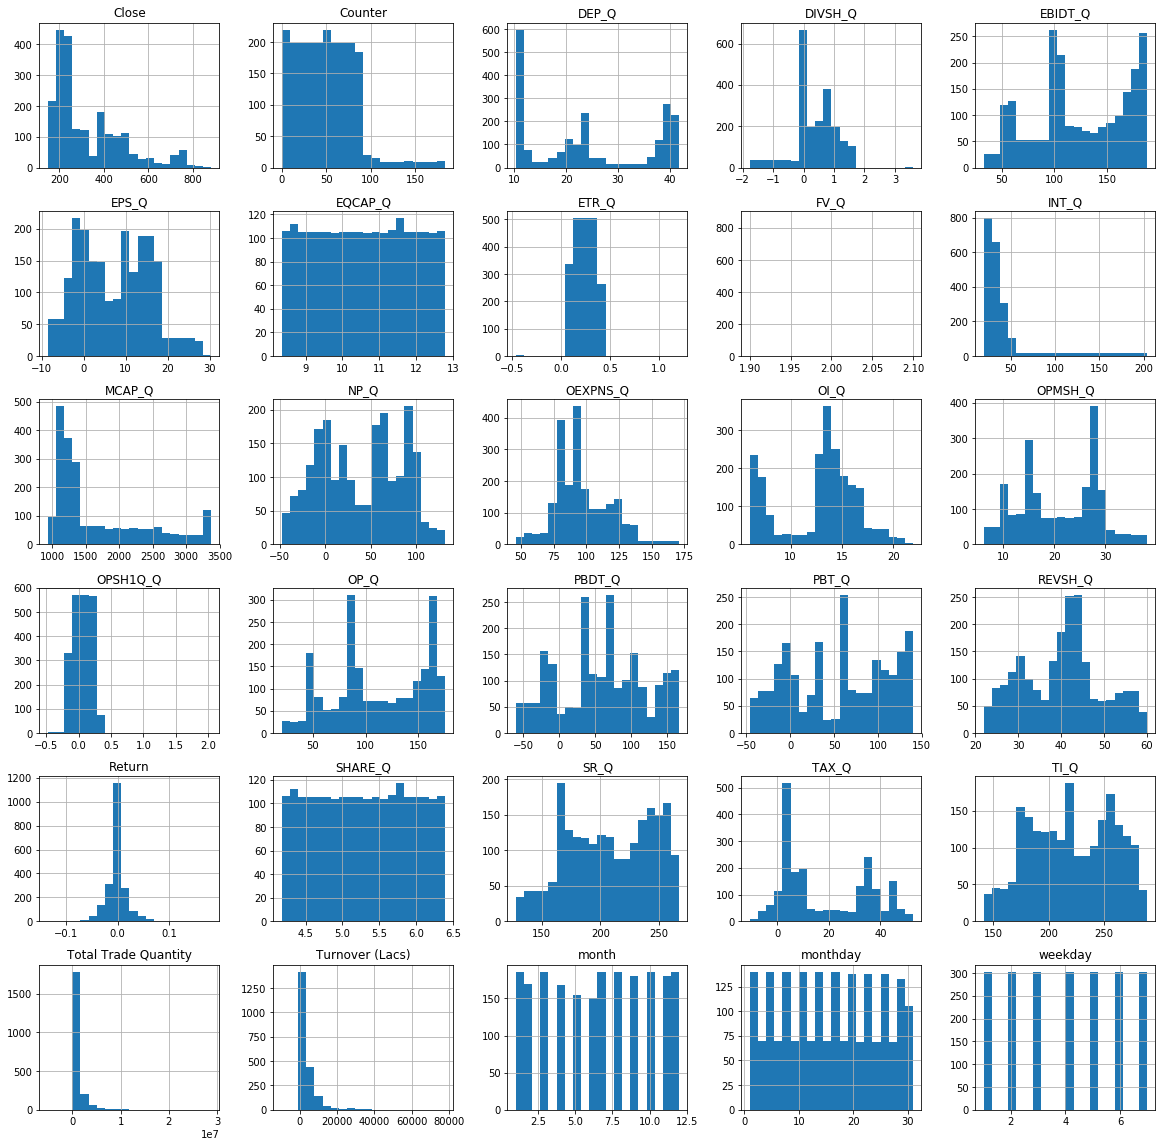

In [91]:
p3[item].hist(bins=20, figsize=(20,20), xlabelsize=10)
# p3[item].to_csv("not_normal.csv")

1. Merge all items by removing index (panel to dataframe)
2. Training Test 

In [92]:
sector_name=w.kwargs["sector_name"]
panel_file_name="Data/"+sector_name+".csv"
    

with open(panel_file_name, 'w') as f:
    for item in p3.items:
        p3[item].to_csv(f, header=False)
        
        
        